In [24]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import cv2


def read_img(image):
    
    img = cv2.imread(image) #this would return a 4-d array: [R,G,B,255]
    img_shape = img.shape
    print(img_shape)

    #get the pixel coordinate
    w = img_shape[1] #the width
    # print(w)
    h= img_shape[0] #the height
    # print(h)
    uv_coord = []
    for u in range(w):
        for v in range(h):
            uv_coord.append([float(u),float(v)])  #this records the coord in the fashion of [x1,y1],[x1, y2], [x1, y3]....
        return np.array(uv_coord)

In [25]:
def add_distortion(sourceUV, dmatrix, Kmatrix):
    '''This function is programmed to remove the pixel of the given original image coords
    input arguments:
    dmatrix          -- the intrinsic matrix [k1,k2,k3,k4] for tweaking purposes
    Kmatrix          -- [fx, fy, cx, cy, s]'''
    u = sourceUV[:,0] #width in x
    v = sourceUV[:,1] #height in y

    rho = np.sqrt(u**2 + v**2) 

    #get theta
    theta = np.arctan(rho,np.full_like(u,1))

    # rho_mat = np.array([rho, rho**3, rho**5, rho**7])
    rho_mat = np.array([theta,theta**3, theta**5, theta**7])

    #get the: rho(theta) = k1*theta + k2*theta**3 + k3*theta**5 + k4*theta**7
    rho_d = dmatrix@rho_mat

    #get phi
    phi = np.arctan2((v - Kmatrix[3]), (u - Kmatrix[2]))
    xd = rho_d * np.cos(phi)
    yd = rho_d * np.sin(phi)

    #converting the coords from image plane back to pixel coords
    ud = Kmatrix[0] * (xd + Kmatrix[4] * yd) + Kmatrix[2]
    vd = Kmatrix[1] * yd + Kmatrix[3]
    return np.column_stack((ud,vd))

In [26]:
import cv2

image = cv2.imread('/OriginalImg.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #the cv2 read the image as BGR

w = img.shape[1]
h = img.shape[0]
uv_coord = read_img(img)

#for adding distortion
dmatrix = [-0.391942708316175,0.012746418822063 ,-0.001374061848026 ,0.005349692659231]

#the Intrinsic matrix of the original picture's 
Kmatrix = np.array([9.842439e+02,9.808141e+02 , 1392/2, 2.331966e+02, 0.000000e+00])

# Kmatrix = np.array([2234.23470710156  ,2223.78349134123,  947.511596277837,   647.103139639432,-3.20443253476976]) #the distorted intrinsics
uv = add_distortion(uv_coord,dmatrix,Kmatrix)

i = 0
dstimg = np.zeros_like(img)

for x in range(w):   #tthe coo
    for y in range(h):
        if i > (512 * 1392 -1):
            break

        xu = uv[i][0] #x, y1, y2, y3
        yu = uv[i][1]
        i +=1

        # if new pixel is in bounds copy from source pixel to destination pixel
        if 0 <= xu and xu < img.shape[1] and 0 <= yu and yu < img.shape[0]:
            dstimg[int(yu)][int(xu)] = img[int(y)][int(x)]

SystemError: <built-in function imread> returned NULL without setting an error

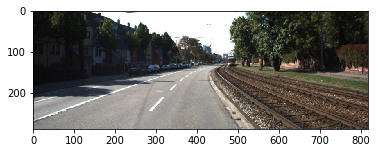

In [17]:
img = Image.fromarray(dstimg, 'RGB')
img.save('my.png')
plt.imshow(img)